# Salary Predictions Based on Job Descriptions

## Part 1 - DEFINE

### ----  the problem ----

Salary is always the hot topic for everyone in the job market. It is not as easy to offer the ideal salary, so how to give out the legitimate salary level which not only saves the budget for the company but also not overlook the candidates' talents becomes the question for us to answer.

###  ----  the goal ----

To set up a reasonable salary level based on various factors. The goal of this project is to build a model which well predicts the test dataset.I trained the model with the train dataset which is very similar with test dataset.

In [1]:
# import your libraries
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

## Part 2 - DISCOVER

###  Load the data 

In [2]:
train_feature = pd.read_csv("data/train_features.csv")
train_target = pd.read_csv("data/train_salaries.csv")
test_feature = pd.read_csv("data/test_features.csv")

### Examine the data

In [3]:
train_feature.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
train_target.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [5]:
test_feature.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


###  Check the type and length of our features

In [6]:
train_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [7]:
train_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [8]:
test_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


### ----  Clean the data ----

####  check to see if there are any missing values in our data set

In [9]:
train_feature.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [10]:
train_target.isnull().any()

jobId     False
salary    False
dtype: bool

In [11]:
test_feature.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

#### Check for duplicates

In [12]:
train_feature.duplicated().sum()

0

In [13]:
train_target.duplicated().sum()

0

In [14]:
test_feature.duplicated().sum()

0

### ----  Explore the data (EDA) ----

In [15]:
# number of jobs
train_feature.shape

(1000000, 8)

#### Summarize numerical and categorical variables separately¶

In [16]:
# summary of the numeric feature
train_feature.describe()

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [17]:
train_feature.describe(include='O')

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684887560,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


#### Merge features and target to a single dataframe

In [18]:
# Merge the features and salaries on jobId
train_df = pd.merge(train_feature, train_target, on='jobId')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [19]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


#### Visualize the target variable

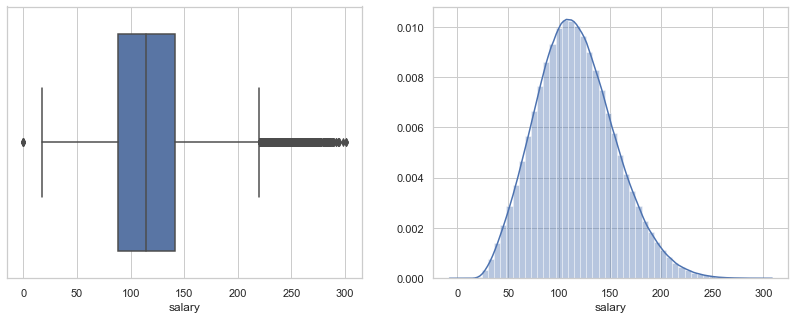

In [20]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.boxplot(train_df.salary)
plt.subplot(1, 2, 2)
sns.distplot(train_df.salary)
plt.show()

#### Identify outliers using IQR rule

In [21]:
stat = train_df.salary.describe()
print(stat)
IQR = stat['75%']-stat['25%']
upper = stat['75%']+1.5*IQR
lower = stat['25%']-1.5*IQR
print('The upper and lower bounds for the potential outliers are {} and {}'.format(upper, lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for the potential outliers are 220.5 and 8.5


#### Examine the outliers

In [22]:
# check potential outlier below lower bound
train_df[train_df.salary < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


It is not reasonable that these entries with zero salary are volunteer or nonprofit work. Therefore, we are confident that they are instances of missing data and should be removed from the training data.

In [23]:
# check potential outlier above upper bound
train_df.loc[train_df.salary > 220.5, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [24]:
# Check most suspicious potential outliers above upper bound
train_df.loc[(train_df.salary > 220.5) & (train_df.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


All of the high-level potential outliers appear to be legitimate. Most of the roles have ~20+ years of experience in high paying industries(Finance,Oil,Web etc). We determine not to remove these outliers from the training set.

In [25]:
# remove data with zero salaries
train_df = train_df[train_df.salary > 8.5]

In [26]:
# check mean salaries based on jobtype
mean = train_df.groupby("jobType")['salary'].mean()
mean

jobType
CEO               145.311425
CFO               135.458547
CTO               135.481067
JANITOR            70.813045
JUNIOR             95.333087
MANAGER           115.368518
SENIOR            105.487775
VICE_PRESIDENT    125.368630
Name: salary, dtype: float64

In [27]:
# re-level the jobtype
train_df["jobType"] = train_df["jobType"].astype('category')
levels = mean.sort_values().index.tolist()
train_df["jobType"].cat.reorder_categories(levels, inplace=True)
train_df

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
...,...,...,...,...,...,...,...,...,...
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149


In [28]:
def magic_plot(df, col):
    '''
    Make plot for each features
    '''
    plt.figure(figsize=(15, 7))
    if df[col].dtype == "int64" or col == 'companyId':
        # plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values,
                         alpha=0.1)
    else:
       # violin plot for categorical variables to compare distributions
        sns.violinplot(x=col, y='salary', data=df, palette="Set2")
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Salary')

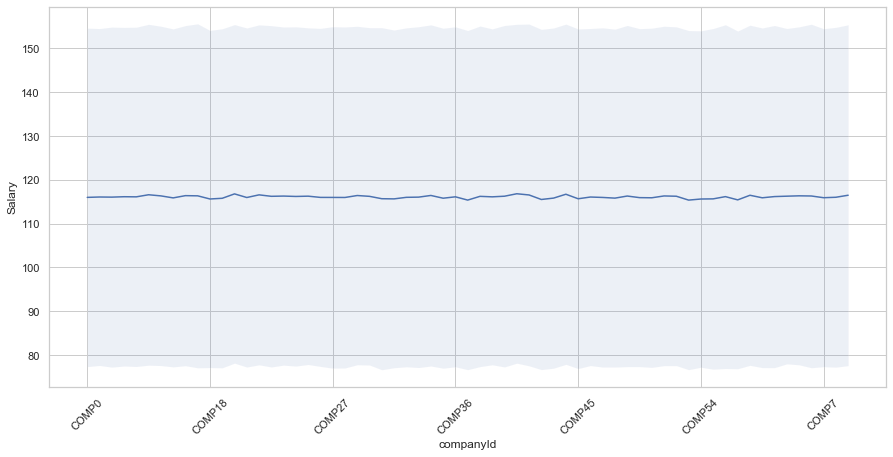

In [29]:
magic_plot(train_df, 'companyId')

There is a weak correlation between company types and salaries.

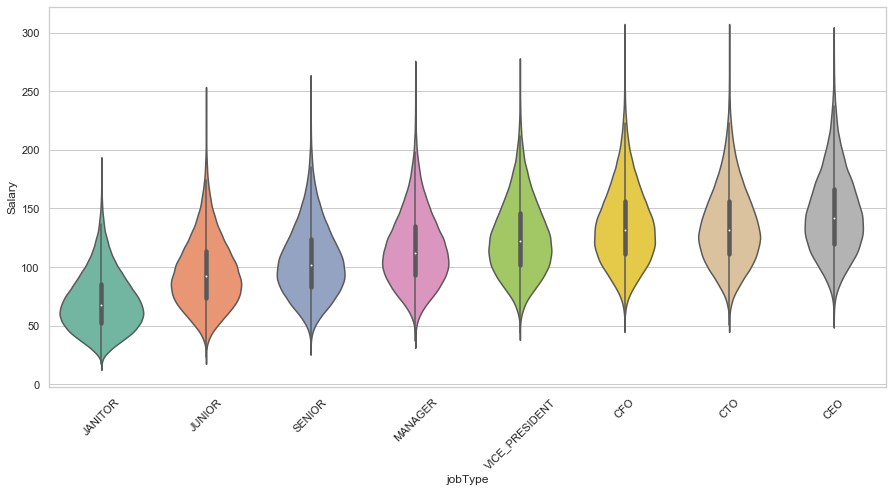

In [30]:
magic_plot(train_df, 'jobType')

There is a clear positive correlation between job type and salary. In general, CEO tends to have the highest salary.

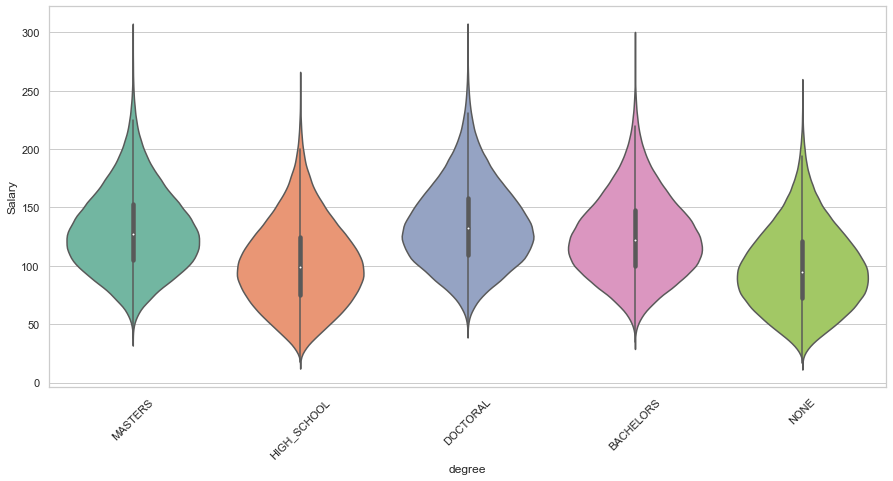

In [31]:
magic_plot(train_df, 'degree')

More advanced degrees tend to correspond to higher salaries.

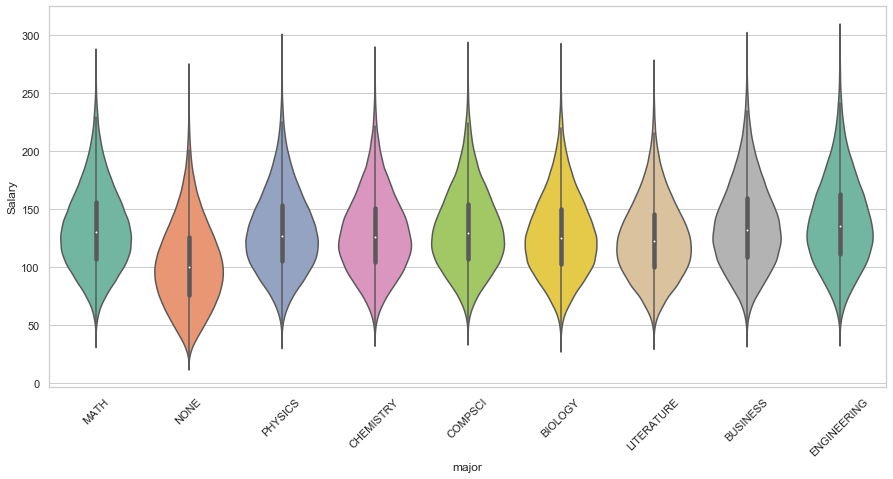

In [32]:
magic_plot(train_df, 'major')

In general, people with math, business and engineering background tend to have higher salaries.

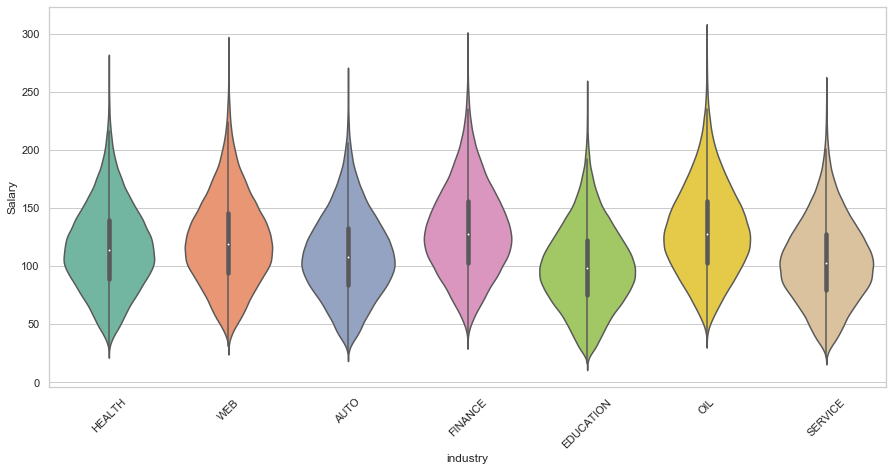

In [33]:
magic_plot(train_df, 'industry')

In terms of industry, web, finance and oil seem to pay better.

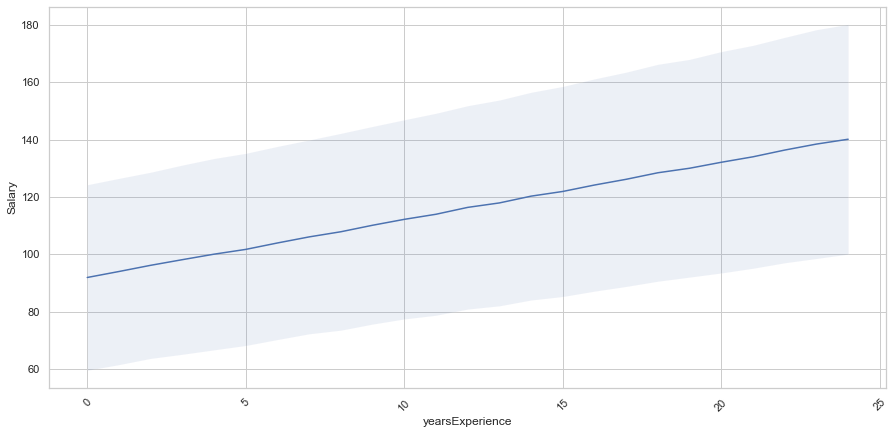

In [34]:
magic_plot(train_df, 'yearsExperience')

Obviously, there is a clear correlation between years of experience and salary.

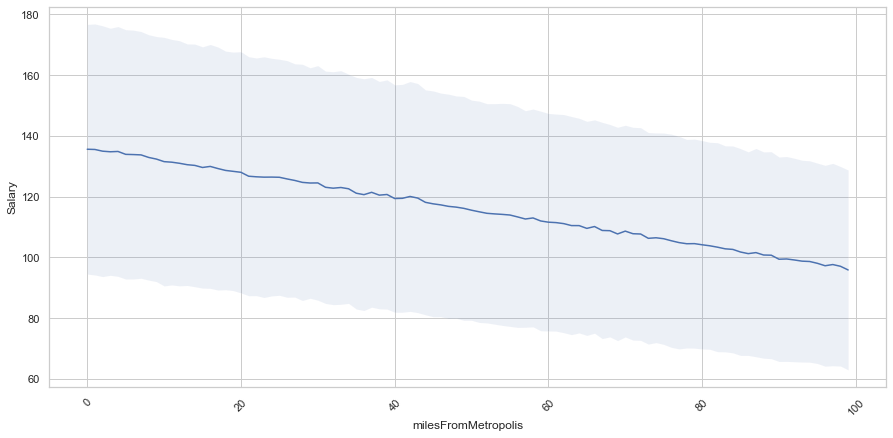

In [35]:
magic_plot(train_df, 'milesFromMetropolis')

The farther from the metropolis, the less salary is.

In [36]:
# change object data type to category
train_df.loc[:, train_df.dtypes == 'object'] = train_df.select_dtypes(
    ['object']).apply(lambda x: x.astype('category'))

In [37]:
df = train_df.drop(['jobId'], axis=1).copy()

In [38]:
df.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [39]:
def cat_to_num(data):
    # encode the categories using average salary for each category to replace label
    for col in data.columns:
        if data[col].dtype.name == 'category':
            feature_dict = {}
            feature_list = data[col].cat.categories.tolist()
            for ft in feature_list:
                feature_dict[ft] = data[data[col] == ft]['salary'].mean()
            data[col] = data[col].map(feature_dict)
            data[col] = data[col].astype('float64')

In [40]:
cat_to_num(df)

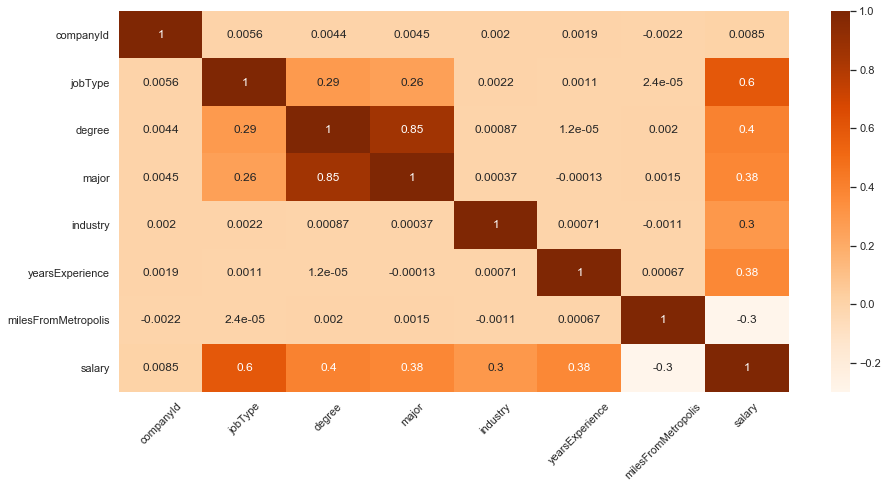

In [41]:
# correlation between selected feature and response
# jobid is discarded because it is unique for individual
fig = plt.figure(figsize=(15, 7))
corr = df.corr()
sns.heatmap(corr, cmap='Oranges', annot=True)
plt.xticks(rotation=45)
plt.show()

We can see that job type is most correlated with salary, followed by degree, major and years of experience.
Among the features, we find that degree and major have a strong correlation and jobtype has a moderate degree of correlation with both degree and major.

### ---- 5 Establish a baseline ----

In [42]:
# create an extremely simple model and measure its efficacy
# e.g. use "average salary" for each jobType as model and then measure MSE
# during 5-fold cross-validation

df_base = train_df.copy()


def avg_pred(data, col):
    feature_dict = {}
    feature_list = data[col].cat.categories.tolist()
    for ft in feature_list:
        feature_dict[ft] = data[data[col] == ft]['salary'].mean()
    data[col] = data[col].map(feature_dict)
    data[col] = data[col].astype('float64')


avg_pred(df_base, "jobType")
predict_base = df_base["jobType"]
target_base = df_base["salary"]
k_folds = KFold(n_splits=5)
mse_list = []

for train, test in k_folds.split(target_base):

    # load train salary data
    train_target = target_base.iloc[train]
    predict_target = predict_base.iloc[train]
    # print the mean squarred error
    mse_list.append(mean_squared_error(train_target, predict_target))

mse_base = np.mean(mse_list)
print("The mean squared error of the baseline model is : {}".format(mse_base))

The mean squared error of the baseline model is : 963.9252996562967


### ----  Hypothesize solution ----

The prediction of our baseline model is based on the data itself without any fitting, feature engineering or tuning, so the result is not ideal. Our goal is to find the best model to beat this baseline model, i.e. get a model with much lower mse score.

3 models that may do a better job than baseline model:
* **Linear Regression**:The simplest model sometimes yields the best results. That is the case of Linear Regression, when the relation between each feature and the target variable is based on a single coefficient. From our EDA, we observe some linear relations, so this model should be a good candidate. We apply both **original linear regression** and **pipeline linear regression**(**standardization** and dimension reduction aka **PCA**). 
* **Random Forest Regression**: A Random Forest is a method of ensemble learning which consists in growing several decision trees in parallel and combining their output to make a prediction. Each decision tree (called ‘weak learner’) is built upon a different random subset of the training set, thereby learning different patterns. In our case, this model will fairly use all of our features.
* **Gradient Boosting Regression**: Gradient Boosting tries to solve an optimization problem: its goal is to reduce a loss function by adding a weak learner at each step. Here we use **XGBoost** for more time efficiency.

## Part 3 - DEVELOP

### ----  Feature engineering  ----

* **"jobID"** is unique for each record in the data, thus it shouldn't be considered into modeling.
* **"companyId","jobType", "degree", "major", "industry"** are categorical variables, they should be applied with one-hot encoding.
* **"yearExperience & "milesFromMetropolis"** are numerical features so they should be kept for modeling.

In [43]:
df_new = train_df.copy()
df_new = pd.get_dummies(
    df_new, columns=["jobType", "degree", "major", "industry", "companyId"])
df_x = df_new.drop(columns=["salary", "jobId"])
df_y = df_new["salary"]

### ----  Create models ----

#### Split train and test set

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    df_x, df_y, test_size=0.33, random_state=0, shuffle=True)

#### Random Forest and Hyperparameter  Tuning

In [61]:
results = []
# Enumerate through different max_depth values and store results
for max_depth in [2, 3, 4, 5, 10, 20, 50, 100]:
    clf = RandomForestRegressor(max_depth=max_depth)
    clf.fit(X_train, y_train)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })

# Display Results
max_depth_df = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_df

,train_error,test_error
max_depth,,
2,1044.826905,1040.062348
3,895.514465,895.372013
4,791.774608,790.365246
5,709.442924,708.813764
10,462.741280,467.469327
20,256.143744,372.831095
50,57.942125,401.022617
100,56.828226,401.119196


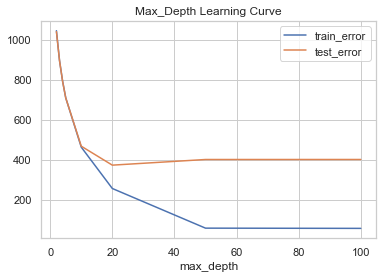

In [69]:
max_depth_df.plot(title="Max_Depth Learning Curve")

max_depth around 20 should be good.

In [71]:
results = []
n_estimator_options = [10, 20, 50, 100, 200, 300, 500]
for n_estimators in n_estimator_options:
    clf = RandomForestRegressor(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    results.append(
        {
            'n_estimators': n_estimators,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })

n_estimators_df = pd.DataFrame(results).set_index('n_estimators').sort_index()
n_estimators_df

,train_error,test_error
n_estimators,,
10,75.064868,427.714864
20,65.039212,413.087349
50,59.005218,404.516216
100,56.873766,401.343886
200,55.854784,399.790937
300,55.516125,399.282605
500,55.239649,398.942800


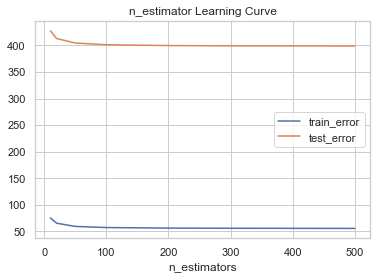

In [73]:
n_estimators_df.plot(title="n_estimator Learning Curve")

n_estimators should range in 100-200 since after 200 we observe a diminishing return(less error dropping but operating time soaring)

In [77]:
results = []
max_features_options = ["auto", "sqrt"]
for max_feature in max_features_options:
    clf = RandomForestRegressor(max_features=max_feature)
    clf.fit(X_train, y_train)
    results.append(
        {
            'max_features': max_feature,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })

max_features_df = pd.DataFrame(results).set_index('max_features').sort_index()
max_features_df

,train_error,test_error
max_features,,
auto,56.809923,401.018343
sqrt,55.798841,392.927394


max_features= sqrt seems to produce a less error.

In [84]:
#grid search with potential candidates with 5-fold cross validation
param_grid = {'n_estimators': [120, 150, 180],
              'max_depth': [20, 25, 30]
              }
rfor_reg = GridSearchCV(RandomForestRegressor(
    max_features='sqrt'), param_grid=param_grid, cv=5, verbose=10, n_jobs=-1)
rfor_reg.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 53.6min
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed: 72.9min remaining: 20.8min
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed: 81.3min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 90.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 90.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [86]:
#get the best model of random forest
rfor_reg.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### XGBoost Hyperparameter Tuning

In [87]:
results = []
# Enumerate through different max_depth values and store results
for max_depth in [2, 3, 4, 5, 10, 20, 50, 100]:
    clf = xgb.XGBRegressor(max_depth=max_depth)
    clf.fit(X_train, y_train)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })

# Display Results
max_depth_df = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_df

,train_error,test_error
max_depth,,
2,363.939005,365.252332
3,359.511936,361.670832
4,356.763389,359.868967
5,354.264790,359.653013
10,297.394129,370.660533
20,32.299904,441.939998
50,1.441386,478.877291
100,1.441385,484.572241


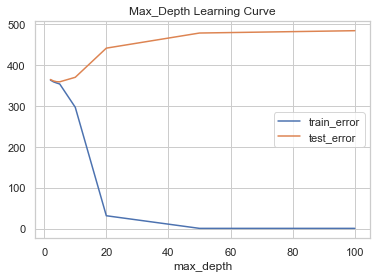

In [88]:
max_depth_df.plot(title="Max_Depth Learning Curve")

max_depth should range in 5-10. After that, it's gonna be overfitting.

In [89]:
results = []
# Enumerate through different max_depth values and store results
for learning_rate in [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1]:
    clf = xgb.XGBRegressor(
        max_depth=2, learning_rate=learning_rate, n_estimators=200)
    clf.fit(X_train, y_train)
    results.append(
        {
            'learning_rate': learning_rate,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })

# Display Results
learning_rate_lr = pd.DataFrame(results).set_index(
    'learning_rate').sort_index()
learning_rate_lr

,train_error,test_error
learning_rate,,
0.05,414.460483,414.787071
0.10,367.830160,369.055335
0.20,359.419276,361.140602
0.40,357.711875,359.322563
0.60,358.204293,359.951662
0.80,357.679913,359.732085
1.00,354.439508,356.278393


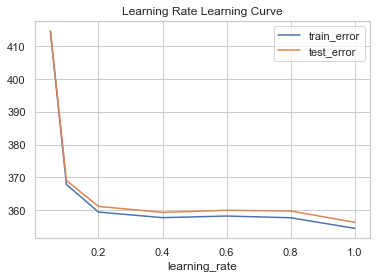

In [90]:
# Plot Learning Rate
learning_rate_lr.plot(title="Learning Rate Learning Curve")

The learning rate should have optimal values between 0.01-0.2. Based on our observation, values greater 0.2 have also been taken into account.

In [91]:
results = []
n_estimator_options = [10, 20, 50, 100, 200, 300, 500]
for n_estimators in n_estimator_options:
    clf = xgb.XGBRegressor(max_depth=2, learning_rate=0.10,
                           n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    results.append(
        {
            'n_estimators': n_estimators,
            'train_error': mean_squared_error(y_train, clf.predict(X_train)),
            'test_error': mean_squared_error(y_test, clf.predict(X_test))
        })

n_estimators_df = pd.DataFrame(results).set_index('n_estimators').sort_index()
n_estimators_df

,train_error,test_error
n_estimators,,
10,2642.903137,2635.028628
20,1005.525655,1001.138444
50,533.035342,531.853070
100,411.460330,411.836401
200,367.830160,369.055335
300,359.619327,361.047584
500,356.659148,358.254038


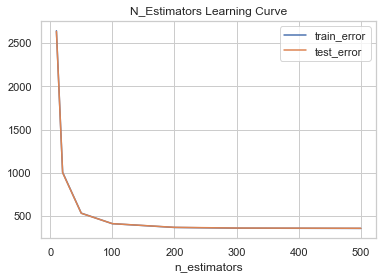

In [93]:
n_estimators_df.plot(title="N_Estimators Learning Curve")

More estimators tend to to have a better model. But value of 300 and 500 do not differ too much. So we just take 400 as our maximum.

In [98]:
# Randomized search to save more time 
param_grid_grad = {'n_estimators': [200, 250, 300, 350, 400],
                   "max_depth": [4, 5, 6, 7],
                   "learning_rate": [0.1, 0.02, 0.2, 0.4, 1]
                   }
gs_cv = RandomizedSearchCV(xgb.XGBRegressor(
), param_distributions=param_grid_grad, cv=5, n_jobs=-1).fit(X_train, y_train)

In [99]:
gs_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### ---- 9 Test models ----

This part will enable us to compare mse of different models and select the best model.

In [110]:
#initialize dicts and lists
models = []
mean_mse = {}
std_mse = {}

In [111]:
# train each model through cross validation and return average mse
def model_training(model, X_train, y_train, mean_mse, std_mse):
    print("MODEL NAME: \n", model)
    neg_mse = cross_val_score(model, X_train, y_train,
                              cv=5, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    std_mse[model] = np.std(neg_mse)
    print('AVERAGE MSE:\n', mean_mse[model])
    print('STANDARD DEVIATION MSE:\n', std_mse[model])

In [112]:
# set up models random forest and XGBoost have been tuned
lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
rfr = RandomForestRegressor(
    n_estimators=150, max_depth=30, max_features='sqrt')
xgbr = xgb.XGBRegressor(n_estimators=400, max_depth=4, learning_rate=0.1)

models.extend([lr, lr_std_pca, rfr, xgbr])

# parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    model_training(model, X_train, y_train, mean_mse, std_mse)

Beginning cross validation
MODEL NAME: 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
AVERAGE MSE:
 384.3498926808524
STANDARD DEVIATION MSE:
 1.1451539780901385
MODEL NAME: 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
AVERAGE MSE:
 384.489519375794
STANDARD DEVIATION MSE:
 1.2260183324510674
MODEL NAME: 
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                     

### ---- 10 Select best model  ----

In [127]:
# choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)


Predictions calculated using model with lowest MSE:
XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=4,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=None, verbosity=None)


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
# train model on entire training set, saves model to disk,
# and scores the "test" dataset

In [3]:
# Test data set transforamtion (the same as train data)
test_df = test_feature.copy()
test_df.loc[:, test_df.dtypes == 'object'] = test_df.select_dtypes(
    ['object']).apply(lambda x: x.astype('category'))
test_df["jobType"].cat.reorder_categories(
    ['JANITOR', 'JUNIOR', 'SENIOR', 'MANAGER', 'VICE_PRESIDENT', 'CFO', 'CTO', 'CEO'], inplace=True)
test_df = pd.get_dummies(
    test_df, columns=["jobType", "degree", "major", "industry", "companyId"])
test_df.drop(columns=["jobId"], inplace=True)

In [160]:
# train model on entire dataset
model.fit(df_x, df_y)

# create predictions based on test data
predictions = model.predict(test_df)

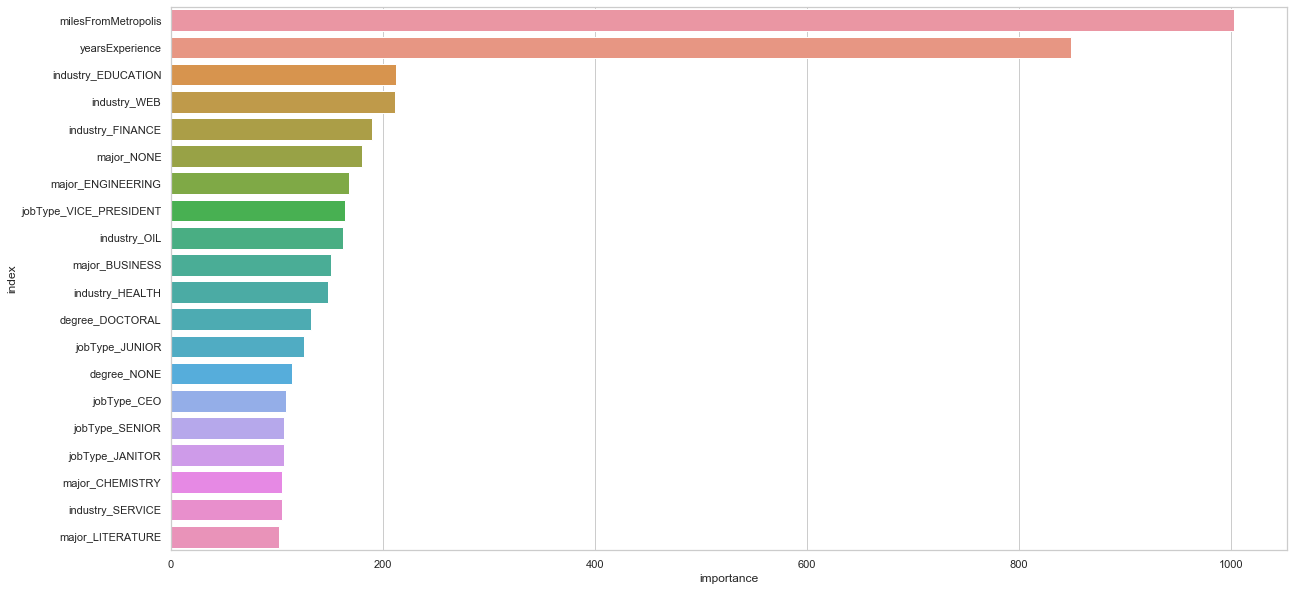

In [167]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
feature_importances = pd.DataFrame(values,
                                   keys,
                                   columns=['importance']).sort_values('importance', ascending=False).reset_index()
plt.figure(figsize=(20, 10))
sns.barplot(x='importance', y='index', data=feature_importances[0:20])

As we can see above, the distance from metro area and level of experience play the most important roles on salary. Additionally, education, web and finance industry seem to affect salary in some degree.

### ---- 12 Deploy solution ----

In [ ]:
# save the prediction and feature importance to a csv file

In [121]:
#save the model
saved_model = pickle.dumps(model)

In [174]:
#export the predictions to csv file
predictions = pd.Series(predictions)
test_df['salary']=predictions
test_feature.to_csv('salary_testprediction.csv')

In [171]:
#export feature importance to csv file
feature_importances.to_csv('feature_importance.csv')